## 1. Regression Methods

### 1.1.1 

date         0
SPX Index    0
dtype: int64


Text(0, 0.5, 'Log Price')

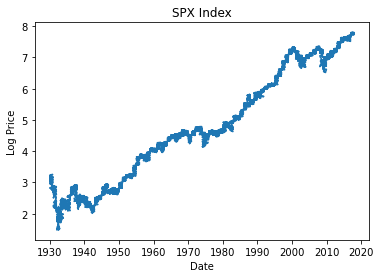

In [2]:
#Importing the necessary libraries and csv files
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

%matplotlib inline
#Reading dates and prices data
px = pd.read_csv("data\priceData.csv", parse_dates =[0])
px.dropna(inplace=True)
print(px.isna().sum()) #calculate the nubmer of nan values)

#Perform log transform of the prices and plotting it
logpx = px.copy(deep=True)
logpx['Log Price'] = np.log(px['SPX Index'])
logpx.drop(['SPX Index'], axis = 1, inplace=True)

plt.plot(logpx['date'], logpx['Log Price'])
plt.title("SPX Index")
plt.xlabel("Date")
plt.ylabel("Log Price")


### 1.1.2

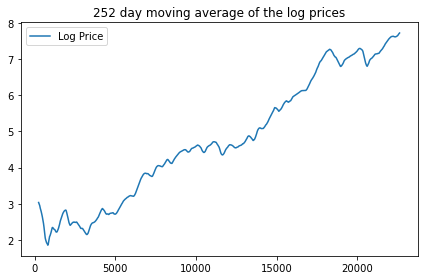

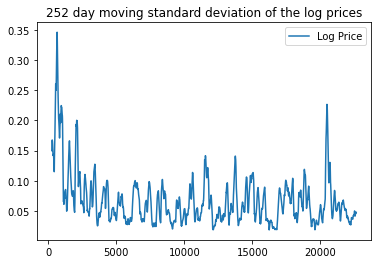

<Figure size 432x288 with 0 Axes>

In [3]:
logpx.rolling(252).mean().plot()
plt.title("252 day moving average of the log prices")
plt.tight_layout()

logpx.rolling(252).std().plot()
plt.title("252 day moving standard deviation of the log prices")
plt.show()
plt.tight_layout()


### Comment on the stationarity of price time-series with reference to your figures.
A loose definition of stationarity is that the first order statistic (mean) and second order statistic(standard deviation) of the distribution does not vary with time. 

The mean of the log prices are not stationary because the mean is clearly increasing over time.

The standard deviation of the log prices do not appear to have a trend however there are spikes within the signal which corresponds to market crashes or corretions. 

The signal is hence non-stationary.

### 1.13 Log Returns and Simple Returns

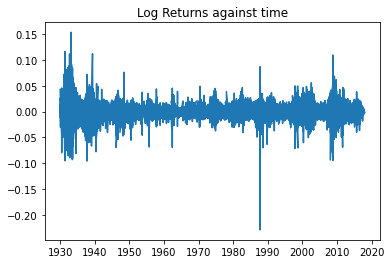

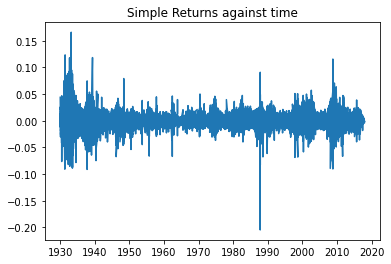

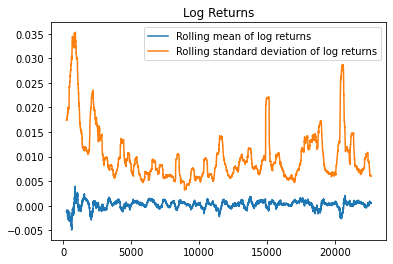

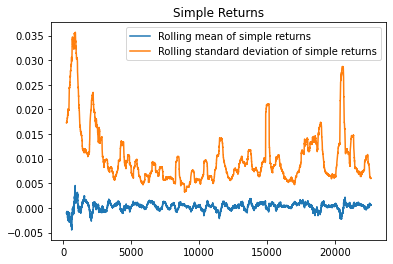

In [4]:
# Log returns
logpx['Log Returns'] = logpx['Log Price'].diff()

#Simple returns

px['Simple Returns'] = px['SPX Index'].pct_change()
plt.plot(logpx['date'],logpx['Log Returns'])
plt.title("Log Returns against time")

plt.figure()
plt.plot(px['date'], px['Simple Returns'])
plt.title("Simple Returns against time")

plt.figure()
logpx['Log Returns'].rolling(252).mean().plot()
logpx['Log Returns'].rolling(252).std().plot()
plt.title("Log Returns")
plt.legend(['Rolling mean of log returns','Rolling standard deviation of log returns'])

plt.figure()
px['Simple Returns'].rolling(252).mean().plot()
px['Simple Returns'].rolling(252).std().plot()

plt.title("Simple Returns")
plt.legend(['Rolling mean of simple returns','Rolling standard deviation of simple returns'])


The rolling mean for both the simple return and log returns have a small oscillatory behaviour around zero which implies a mean-reverting nature of this time-series.

### 1.1.4 Suitability of log returns over simple returns for signal processing practices.

First of all log is monotonically increasing and preserves relative ordering of numbers.
 
The taylor expansion of $log(1+x) = x - x^/2 + x^3/3....$ 

When x is small, $log(1+x) \approx x $

For short period returns, such as daily returns, the absolute value of it : $\frac{r_{t} - r_{t-1}}{r_{t-1}}$ tends to be small.

The log returns $log(r_{t}) - log(r_{t-1}) = log\frac{r_{t}}{r_{t-1}}$
Given that $\frac{r_{t}}{r_{t-1}}$ is small, we can approximate the log returns as $\frac{r_{t}}{r_{t-1}} - 1 = \frac{r_{t}- r_{t-1}}{r_{t-1}}$. That is the return is approximately the log-returns. 
 A consequence of that is that the log-returns are normally distributed which is handy given many statistical techniques presumes normality. Logarithms also provide better numeric stability for various algorithms. This can be further verified with the plots generated below.





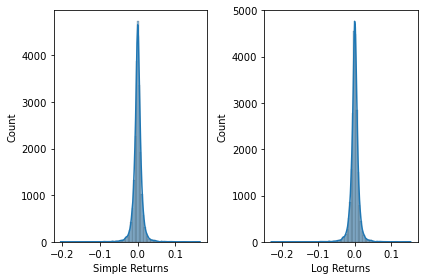

In [5]:
import scipy.stats as st
import seaborn as sns

fig, ax = plt.subplots(1,2)
sns.histplot(px['Simple Returns'], bins = 100, kde = True, ax = ax[0])
sns.histplot(logpx['Log Returns'], bins = 100, kde = True, ax = ax[1])
fig.show()
fig.tight_layout()







Another way to verify the 'Gaussianity' of the data is through the Jarque-Bera goodness of fit test. It measures whether sample data have the skewness and kurtosis matching a normal distribution, which has S (skewness) = 0 and C (kurtosis) = 3.

\begin {equation}
\mathit{JB} = {\frac{n}{6}} (S^{2} + \frac{1}{4}(K-3)^{2}) \tag{1}
\end{equation}

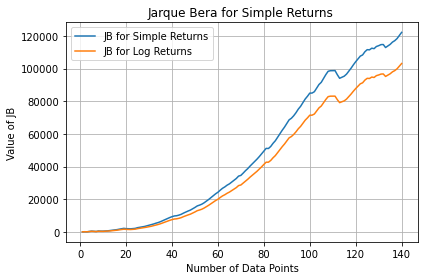

In [6]:
from scipy import stats 
start = 100 ; step = 100
steps = [i for i in range(start, len(px['Simple Returns']), step)]
num_data_points = list(map(lambda x: int(x/step), steps))
simple_JB = [stats.jarque_bera(px['Simple Returns'].dropna()[:s])[0] for s in steps]
log_JB = [stats.jarque_bera(logpx['Log Returns'].dropna()[:s])[0] for s in steps]

# How to plot with axes
fig, ax = plt.subplots()
ax.plot(num_data_points[:140],simple_JB[:140], label = 'JB for Simple Returns')
ax.plot(num_data_points[:140],log_JB[:140], label = 'JB for Log Returns')
ax.title.set_text('Jarque Bera for Simple Returns ')
ax.grid('on')
ax.legend()
ax.set_xlabel("Number of Data Points")
ax.set_ylabel("Value of JB")
fig.tight_layout()


It can be seen as the number of data points increases, the Jarque Bera statistic is increasing. It increases more gradually more gradually for log-returns which implies that log-returns deviate more slowly from a normal distribution proving our previous point of why it is widely used in the signal-processing domain.

### 1.1.5 £1 stock purchase example with log-returns

|$\Delta$ in Stock Price |Simple Returns |Log Returns|
|---|---|---|
|1.00 -> 2.00 | 1.00  | 0.69  |
|2.00 -> 1.00 | -0.5  | -0.69  |

Even though the stock price have no change relative to the initial price of a pound, the simple returns are unequal in magnitude as it is always relative to the starting price you are using. The log returns however are symmetric and sum up to zero
, giving us a clear understanding that the asset did change in value.

### 1.1.6 When should you use simple returns over log returns ? 

In the Markowitz portfolio optimization model, we aim to find a weight vector $\omega$ (vector that contains weighting of each asset) that minimizes the risk measured by the variance $\omega^{T}\Sigma\omega$.

When formulating such a portfolio, we often calculate the mean return by using the simple return vector $r$ which contains the mean return of each individual asset in the portfolio weighted by $\omega$. Hence the mean return can be expressed as $\bar{r} = \omega^{T}{r}$. If we were to use log-returns to model this problem, the expected log-returns will not be a simple weighted-average of the log-returns.


### 1.2 ARMA vs ARIMA models for financial applications

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR
import copy

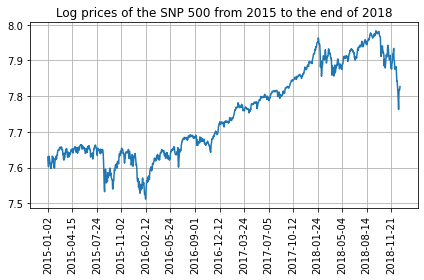

In [8]:
snp = pd.read_csv('data\snp_500_2015_2019.csv')
date = snp['Date']
snp.set_index(['Date'], inplace = True)
snp_close = snp['Close'].to_frame().apply(np.log)

plt.plot(snp_close)
plt.xticks(date[::70], rotation = 'vertical')
plt.title('Log prices of the SNP 500 from 2015 to the end of 2018')
plt.grid('on')
plt.tight_layout()

Based on the graph above, the log prices of the S&P 500 is non-stationary because there is a steady upward trend over time implying that the mean is increasing. The time-variant first and second order statistics suggest the unsuitability of the ARMA model for this specific time-series as it presumes stationarity. The ARIMA model however has an initial 'differencing step' that can be applied to eliminate the non-stationarity of the mean hence it would be more suitable to use the ARIMA model

### 1.2.2 Fitting an ARMA(1,0) to the S&P 500 index

The model parameter of this AR(1) model is 0.99736. The price signal can then be formulated mathematically as : 
$$
\begin{equation*}
X_{t} = 0.99736X_{t-1} + \epsilon_{t} \tag{2}
\end{equation*}
$$

This model parameter 0.99736 is close to 1 which means the fitted signal is simply a random walk.

This explains why under close inspection, the fitted signal lags the true signal. The AR(1) model is not useful in practice because it just states that the price movement in the next time step is a random walk based on the price from the previous time step. Future movements are unpredictable and are equally likely to be up or down which is a naive forecast.

C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

const     7.748867
ar.L1     0.997354
sigma2    0.000074
dtype: float64
Sum of Residuals 0.07770956975214016


Text(0.5, 0, 'Date')

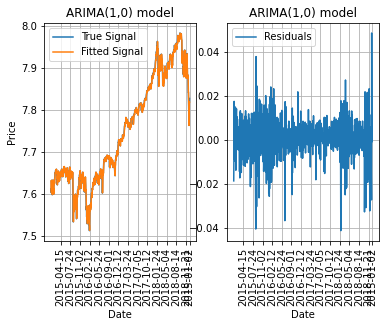

In [9]:
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['True']
model = ARIMA(snp_arma, order=(1,0,0)).fit()
snp_arma['Res'] = ARIMA(snp_arma, order=(1,0,0)).fit().resid #(AR,Differences,MA)
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res']

sum_of_residuals = snp_arma['Res'].sum()

print(model.params)
print("Sum of Residuals", sum_of_residuals)
fig, ax = plt.subplots(1,2)
ax[0].plot( snp_arma['True'][1:], label = 'True Signal')
ax[0].plot( snp_arma['Prediction'][1:], label = 'Fitted Signal')
ax[0].set_xticks(date[::70])
ax[0].set_xticklabels(date[::70],rotation = 90)
ax[0].title.set_text('ARIMA(1,0) model')
ax[0].grid('on')
ax[0].legend()
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")


ax[1].plot( snp_arma['Res'][1:], label = 'Residuals')
ax[1].set_xticks(date[::70])
ax[1].set_xticklabels(date[::70],rotation = 90)
ax[1].title.set_text('ARIMA(1,0) model')
ax[1].grid('on')
ax[1].legend()
ax[1].set_xlabel("Date")







### |1.2.3 Fitting an ARIMA(1,1,0) model with differencing

The ARIMA model with differencing removes sources of non-stationarity by applying a differencing step of order 1. The mathematical model for this section can be modelled as : 
$$
\begin{equation*}
\Delta X_{t} = -0.008170 * \Delta X_{t-1} + \epsilon_{t} \tag{3}
\end{equation*}
\\ \\
\begin{equation*}
where \Delta X_{t} = X_{t} - X_{t-1}
\end{equation*}
$$

Since $\epsilon_{t}$ take values that are much larger than -0.008170 * $\Delta X_{t-1}$ we could approximate the expression such that $\Delta X_{t} \approx \epsilon_{t}$ which results in the same conclusion as of equation (2), which indicates that the future value is a random walk.


C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

Sum of residuals for ARIMA 7.828324256613874
ar.L1    -0.008170
sigma2    0.000074
dtype: float64


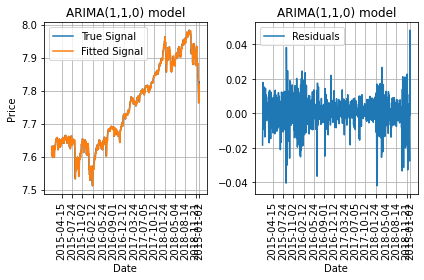

In [10]:
snp_arima = copy.deepcopy(snp_close)
snp_arima.columns = ['True']
model_arima = ARIMA(snp_arima, order=(1,1,0)).fit()
snp_arima['Res'] = ARIMA(snp_arima, order=(1,1,0)).fit().resid #(AR,Differences,MA)
snp_arima['Prediction'] = snp_arima['True'] - snp_arima['Res']

sum_of_residuals = snp_arima['Res'].sum()
print("Sum of residuals for ARIMA", sum_of_residuals)
print(model_arima.params)
fig, ax = plt.subplots(1,2)
ax[0].plot( snp_arima['True'][1:], label = 'True Signal')
ax[0].plot( snp_arima['Prediction'][1:], label = 'Fitted Signal')
ax[0].set_xticks(date[::70])
ax[0].set_xticklabels(date[::70],rotation = 90)
ax[0].title.set_text('ARIMA(1,1,0) model')
ax[0].grid('on')
ax[0].legend()
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")


ax[1].plot( snp_arima['Res'][1:], label = 'Residuals')
ax[1].set_xticks(date[::70])
ax[1].set_xticklabels(date[::70],rotation = 90)
ax[1].title.set_text('ARIMA(1,1,0) model')
ax[1].grid('on')
ax[1].legend()
ax[1].set_xlabel("Date")

fig.tight_layout()

### Vector Autoregressive (VAR) models


### 1.3.1 Rewriting the VAR model in concise matrix algebra form.

The equation can be rewritten using matrix algebra.
as 

\begin{equation}

Y = BZ + U  \tag{4}
\end{equation}
with : 

\begin{align*}
B &= [c,A_{1},A_{2} ... ,A_{p}] \\
Z &= [1 ,y_{t-1}, y_{t-2}.... ,y_{t-p}]^{T} \\
Y &= y_{t} \\
U &= e_{t} \\
\end{align*}

### 1.3.2 $B_{opt}$

The optimal coefficients in the $L_{2}$ norm sense can be found by posing this as a least-squares problem.

\begin{equation}
\min_{B} ||Y-BZ||^{2}_{2} \tag{5}
\end{equation}

This problem has an analytical solution which could be found by taking the derivative of the objective function.
Let F be the $L_{2}$ norm of $||Y-BZ||$.
\begin{equation*}
\begin{align*}
F = &(Y-BZ)^{T}(Y-BZ) \\
  = & Y^{T}{Y} - 2Y^{T}BZ + (BZ)^{2} \\
\frac{\partial F}{\partial B} =& -2Y^{T}Z + 2(BZ)Z^{T}
\end{align*}
\end{equation*}

Setting the partial derivative to zero gives 
\begin{align*}
&-2Y^{T}Z + 2(BZ)Z^{T} = 0  \\
&B(ZZ^{T}) = Y^{T}Z \\
&B = Y^{T}Z(ZZ^{T})^{-1} \\

\end{align*}

We obtain $ B_{opt}= Y^{T} Z(ZZ^{T})^{-1}$



### 1.3.3 Eigvenvalues of A must be less than 1 in absolute value

\begin{equation}
y_t = Ay_{t-1} + e_{t} \tag{6}
\end{equation}

Substituting the equation (6) recursively, we are able to express $y_{t}$ in terms of $\{y_{0}, y_{1} .... y_{t-1}\}$, $A$ and $\{e_{1}, e_{2} ... e_{t}\}$ as : |

\begin{equation}
    y_{t} = \sum_{i=0}^{t-1} (A^{i}e_{t-i}) + A^{t}y_{0} \tag{7}

\end{equation}


For numerical stability, we require tha the eigenvalues of A are lesser than 1, otherwise the values of $y_{t}$ may tend to infinity.

### 1.3.4

In [11]:
from statsmodels.tsa.api import VAR
from IPython.display import display

In [12]:
df = pd.read_csv('data/snp_allstocks_2015_2019.csv')
df = df.set_index('Date')

info = pd.read_csv('data/snp_info.csv')
info.drop(columns=info.columns[0], inplace=True)


In [13]:
tickers = ["CAG", "MAR", "LIN", "HCP", "MAT"]
stocks = df[tickers]
stocks_ma = stocks.rolling(window = 66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

#fit a VAR(1) model to the time-series, and compute eigenvalues of A
model = VAR(stocks_detrended)
results = model.fit(1)
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)

tmp = pd.DataFrame(A,columns=tickers)
tmp.index = tickers

print(f"eigenvalues of A : {eigA}")
display(tmp)






eigenvalues of A : [0.71449288+0.12927613j 0.71449288-0.12927613j 1.00635964+0.j
 0.86051894+0.j         0.91144512+0.j        ]


C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,CAG,MAR,LIN,HCP,MAT
CAG,0.872786,0.113179,-0.281265,0.011912,0.058776
MAR,-0.063745,0.895820,-0.184820,-0.005004,0.022917
LIN,0.000134,-0.111678,0.704023,0.004982,-0.025557
HCP,-0.084776,-0.083831,-0.401417,0.931708,-0.046406
MAT,0.643072,0.094931,2.033036,-0.012884,0.802974


1. Firstly, this decompositions show's that stock price at the next time step mostly depends only on the price of itself from the previous step. 

2. The future price of CAG has a correlation with the price of MAT. If MAT moves in one direction, CAG will likely move in the same direction.

3. The future price of LIN also has a correlation with the price of MAT.

Since CAG MAR and LIN have a significant correlation in stock price, this would not be a well-diversified portfolio as prices move together causing it to have a large variance.


The third eigenvalue also has a magnitude > 1 which will result in instability of the model after a long period of time.


## 1.3.5

In [14]:
max_eigen_values = []
mean_eigen_values = []
num_stocks = []


for sector in info['GICS Sector'].unique() : 
    tickers = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    stocks = df[tickers]
    stocks_ma = stocks.rolling(window = 66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()

    #fit a VAR(1) model to the time-series, and compute eigenvalues of A
    model = VAR(stocks_detrended)
    results = model.fit(1)
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)

    tmp = pd.DataFrame(A,columns=tickers)
    tmp.index = tickers

    max_eigen_values.append(eigA.max())
    mean_eigen_values.append(eigA.mean())
    num_stocks.append(len(tickers))


results = pd.DataFrame(info['GICS Sector'].unique(), columns=["Sector"])
results['# of Stocks'] = num_stocks
results['Max Eigenvalue'] = max_eigen_values
results['Mean Eigenvalues'] = mean_eigen_values

results
    

C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\zackx\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

,Sector,# of Stocks,Max Eigenvalue,Mean Eigenvalues
0,Industrials,69,0.991568+0.017404j,0.750818-0.000000j
1,Health Care,62,0.993598+0.033204j,0.441843+0.000000j
2,Information Technology,68,0.992075+0.036269j,0.803445+0.000000j
3,Communication Services,26,0.982234+0.007508j,0.925770+0.000000j
4,Consumer Discretionary,65,0.989860+0.039565j,0.804006+0.000000j
5,Utilities,27,0.983506+0.064941j,0.463644+0.000000j
6,Financials,68,1.003000+0.051864j,0.418911+0.000000j
7,Materials,26,0.990101+0.057061j,0.481792-0.000000j
8,Real Estate,31,0.982744+0.009006j,0.918568+0.000000j
9,Consumer Staples,33,0.991324+0.019122j,0.849384-0.000000j


After performing eigenanalysis, it is worthwhile noticing that not all sectors have their *intra-sector* tickers moving in tandem. This is evident in the Industrials, HealthCare, Utilities, Financials and Materials sectors where future stock price movement of *intra-sector* tickers have a low mean eigenvalue. This low *intra-sector* correlation implies that it is worthwhile diversifying across these 5 sectors.
The portfolio manager can then diversify *across sectors* by buying from the other 5 sectors with high intra-sector correlation (Information Technology, Communication Services, Real Estate, Energy) to minimize the volatility of the portfolio.

## 2. Bond Pricing

### 2.1 Examples of Bond Pricing

\begin{equation*}
FCF  = NPV  (1+\frac{r}{n})^{nt}  \tag{8}
\end{equation*}
\begin{equation*}
r = n[(\frac{FCF}{NPV})^{\frac{1}{nt}} - 1] \tag{9}
\end{equation*}

NPV is the net present value or in our case the initial investment made. \
While FCF is the future cash flow we will receive at the end of the time period $t$. \
$n$ is the compounding frequency 

1. Annual Compounding
$n =1, t=1, FCF = 1100, NPV = 1000$ this gives 
\begin{equation*}
r = 10\% 
\end{equation*}

2. Semi-annual Compounding
$n =1, t=1, FCF = 1100, NPV = 1000$ this gives 
\begin{equation*}
r = 9.76\%
\end{equation*}

3. Monthly compounding
$n=12, t=1, FCF =1100, NPV = 1000$ this gives
\begin{equation*}
r = 9.57\%
\end{equation*}

4. Continuous Compounding
$n \rightarrow {\infty}, t=1, FCF = 1100, NPV = 1000 $

Knowing the fact that as $n \rightarrow {\infty}$, the expression of FCF can be reduced to an exponential.
\begin {equation*}
\begin {aligned}
FCF =& \lim_{n->\infty} NPV(1+\frac{r}{n})^{nt} \\
FCF =&  NPV(e^{rt}) \tag{10}
\end{aligned}
\end{equation*}

We can then rewrite r as 
\begin{equation*}
r = \frac{ln(\frac{FCF}{NPV})}{t}
\end{equation*}

which gives 
\begin{equation*}
 r= 9.53 \%
\end{equation*}

### 2.1.2 Equivalent rate of interest for continuous compounding
We find the equivalent rate of interest for continuous compounding by equating their future cash flow.
For monthly compounding, we plug in n = 12, 

\begin{align*}
FCF_{cont} = FCF_{monthly}\\
NPV e^{r_{cont}t} = NPV (1+\frac{r_{monthly}}{n})^{nt} \\
e^{r_{cont}} = (1+\frac{0.15}{12})^{12} \\
r_{cont} = \ln(1+\frac{0.15}{12})^{12} \\
r_{cont} = 14.9\% \\
\end{align*}

### 2.1.3 Interest paid for continuous compounding

On a $10,000 deposit with continuous compounding, quarterly interest can be calculated by using the continuous compounding equation (10) : 

$Q1 = 10000(e^{0.12*1/4} -1) = \$304.55 $ 

$Q2 = 10000(e^{0.12*2/4}-1) - Q1 = \$313.82$

$Q3 = 10000(e^{0.12*3/4} -1) - Q1 - Q2 = \$323.38$

$Q4 = 10000(e^{0.12}-1) - Q1 - Q2 - Q3 = \$333.23 $


### 2.2 Forward rates

**a) Would you be happy to earn that extra 9% for investing for two years rather than one?** \
Theoretically the forward rates of interest between $f_{1,2}$ have already been implied in the two-year interest rate. The 9% 'extra return' we've obtained would be the same as investing in the one-year interest rate now, and taking all the proceeds and reinvest in the one-year interest rate one year later (provided that market expectations remain the same). So there is nothing particularly exciting or special about this opportunity.



**b)  Comment on the 5%, 7%, and 9% investment strategies**
1. 5% - If the investor needs the capital invested in one-year this is the only sound option. 
2.   7% - If the investor has predictions that rates will go down much lower one year from now than the implied forward rate $f_{1,2}$, and he also doesn't need this capital for 2 years from now then this is a good option. The investor can lock in a higher return with the current interest rate by investing in the two year strategy provided that his predictions are right. 
3.   9% - The investor has predictions that rates may go up higher than the implied forward rate $f_{1,2}$ one year from now. This investor can reinvest his proceeds from the first year to the spot rate one year from now.

**c) Comment on the advantages and disadvantages of the forward rate of 9%.**

The advantage of forwards rate of 9% is that it is the reflection of all market participants on what the interest rate one year from now should be as they are based on market expectations. The disadvantage is that it is subject to interest rate fluctuations and will change with time.


**d) How much would you need to go from 1y investment to 2y investment and what does it depend upon?** 

I would have to believe that the interest rate one year from now would be lesser than 9% for me to invest in the 2 year strategy. For this situation to play out, it would have to depend| on the future macro-environment and the decisions made by central banks.




### 2.3 Duration of a coupon bearing bond

**a) Calculate the duration for the 1% bond in the Table**

The duration of the bond is simply the sum of the weighted averages show in the 4th row of the table. 

\begin{equation*}
0.0124 + 0.0236 + 0.0337 + 0.0428 + 0.0510 + 0.0583 + 6.5377 = 6.7595 
\end{equation*}

**b) Calculate the modified durations for the 1 % bonds in the above table, and elaborate on the differences from the calculation in Part a).**
\begin {aligned}
D_{M}=& \frac{duration}{1+yield} \\
     =& \frac{6.7595}{1+0.05} \\
     =& 6.438\%
\end{aligned}

The modified duration measures the percentage change of price with respect to yield while duration(Macaulay duration) is just the weighted average time until cash flows are received. Their numerical values are quite similar as they only differ by a factor of (1+YTM)


**c) Explain why duration (or modified duration) are convenient measures to protect the pension plan against unexpected changes in interest rates.**




Firstly, the pricing of a bond is inversely proportional to interest rate fluctuations. So bond prices are subject to interest rate risks. We can write the taylor's expansion of the price of the bond with respect to the YTM $\lambda$ as 

\begin{equation}
P(\lambda) = P(\lambda_{0}) + \frac{dP(\lambda_{0})}{\lambda}(\lambda - \lambda_{0}) + 
\frac{1}{2}\frac{d^{2}P(\lambda_{0})}{d\lambda^{2}}(\lambda-\lambda_{0})^{2} + ....  \tag{11}
\end{equation}

Pension funds can then mitigate risks of changing interest rates $d\lambda$ by matching first and second order terms of P which is simply a scalar multiple of the modified duration and the derivative of the modified duration respectively.


<!-- c)
\begin{aligned}


\end{aligned} -->

### 2.4 Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv(r'data/fsp_case_31_BSD.csv', index_col=0, header=[0,1])
df.index = pd.to_datetime(df.index)


df['ret'].mean(axis=1)

2017-01-02    0.007347
2017-01-03    0.000909
2017-01-04   -0.002181
2017-01-05    0.002953
2017-01-06    0.000993
                ...   
2018-12-25    0.000000
2018-12-26    0.000936
2018-12-27   -0.017501
2018-12-28    0.017471
2018-12-31    0.005764
Length: 521, dtype: float64

### 2.4.1 The estimated market returns per day : 

The 157 European companies averaged a return of 0.0046% a day across the 2017-2019 timeframe.

In [16]:
print(f"Estimated market returns per day for the 157 European companies : {np.round((df['ret'].mean(axis=1)*100).mean(),4)}%")

Estimated market returns per day for the 157 European companies : 0.0046%


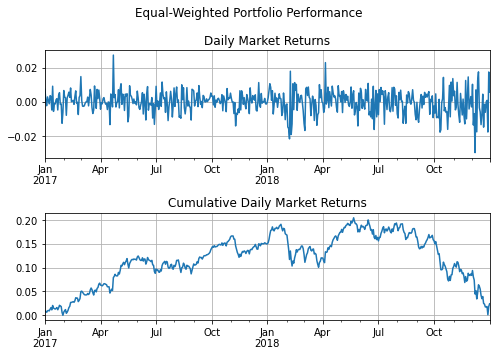

In [17]:
unweighted_returns = df['ret'].mean(1)
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle("Equal-Weighted Portfolio Performance")
unweighted_returns.plot(ax=ax1, grid=True)
unweighted_returns.cumsum().plot(ax=ax2, grid=True)

ax1.set_title("Daily Market Returns")
ax2.set_title("Cumulative Daily Market Returns")
fig.set_size_inches(7,5)
fig.tight_layout()

### 2.4.2 Estimate a rolling beta, $\beta_{i,t}$ for each company i, with the rolling window of 22 days.

The market beta $\beta_{i}$ is defined as : 

\begin{equation}
\beta_{i} = \frac{Cov(R_{i},R_{m})}{Var({R_{m})}} \tag{12}
\end{equation}

A 22 days rolling $\beta_{i,t}$ would be a time series of $\beta s$ estimated throughout the 2 year time period. We take $R_{m}$ to be the equally-weighted average return of the 157 European companies.


In [18]:
""""
Function that calculates the rolling_beta of a dataframe of Dates X Companies
Returns a pandas dataframe that contains the rolling_betas with number of rows = df - period
"""
def rolling_beta (period,df,weighted=False, market_returns=None) : 
    Beta_t_2d_list = []
    for t_1, t_2 in zip(df.index[0:],df.index[21:]) : 
        R_i = df[t_1:t_2]['ret']
        if not weighted : ## equally weighted
            R_m = pd.Series(df[t_1:t_2]['ret'].mean(axis=1))
        else :  ##market-cap weighted
            R_m = market_returns[t_1:t_2]
        Beta_t_vals = []
        for name, data in  R_i.iteritems() :
            Beta = R_m.cov(data) / R_m.cov(R_m)
            Beta_t_vals.append(Beta)
        Beta_t_2d_list.append(Beta_t_vals)

    Beta_df = pd.DataFrame(Beta_t_2d_list, index = df['ret'].index[21:],columns = df['ret'].columns)

    return Beta_df

equal_weighted_beta = rolling_beta(period=22, df=df, weighted=False)





<AxesSubplot:title={'center':'Equally-Weighted Beta Histogram'}, ylabel='Frequency'>

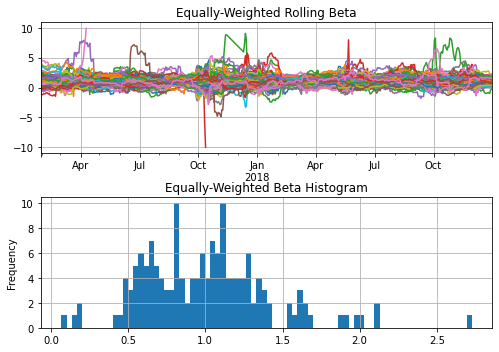

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_title("Equally-Weighted Rolling Beta")
ax2.set_title("Equally-Weighted Beta Histogram")
fig.set_size_inches(7,5)
fig.tight_layout()

for col in equal_weighted_beta.columns : 
    tmp = equal_weighted_beta[col][equal_weighted_beta[col].between(-10,10)] #filter values with betas that are too high
    tmp.plot(ax=ax1, grid=True)

equal_weighted_beta.mean().plot.hist(ax=ax2,bins=80,grid=True)






Beta measures the expected move in a stock relative to movements in the overall market. It is a key component of the CAPM model and can be used in calculating the cost of equity funding.

$ \beta < 0$ means that the asset moves in opposite directions with the market portfolio.

$0 < \beta < 1$ means that the asset moves with the market portfolio but with lower magnitudes.

$\beta > 1$ means that the asset moves with the market portfolio and does it with amplified magnitudes. (Gains and losses are amplified)

Negative beta stocks are rare, in the Equally-Weighted Rolling Beta plot you can see only a handful of stocks have negative beta on average.

### 2.4.3 Estimating the market-cap weighted market return $R_{m}$


\begin{equation}
R_{m} = \sum_{i} \frac{mcap * ret_{i}}{\sum_{i}mcap_{i}} \tag{13}
\end{equation}

The return of the market is the sum of the returns of individual equities weighted by their market capitalization 
$w = \frac{mcap_{i}}{\sum_{i}mcap_{i}}$. 

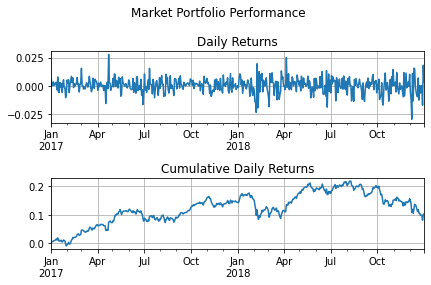

In [20]:
total_market_cap = df['mcap'].sum(axis=1)
market_returns = df['ret'].multiply(df['mcap'])
R_m = market_returns.sum(axis=1).divide(total_market_cap)

fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle("Market Portfolio Performance")
R_m.plot(ax=ax1, grid=True)
R_m.cumsum().plot(ax=ax2, grid=True)
ax1.set_title("Daily Returns")
ax2.set_title("Cumulative Daily Returns")
fig.tight_layout()


### 2.4.4 Estimating a market-cap-weighted $\beta$

In [21]:
cap_weighted_beta_df = rolling_beta(22,df,weighted=True,market_returns=R_m)

<AxesSubplot:title={'center':'Market-Weighted Beta Histogram'}, ylabel='Frequency'>

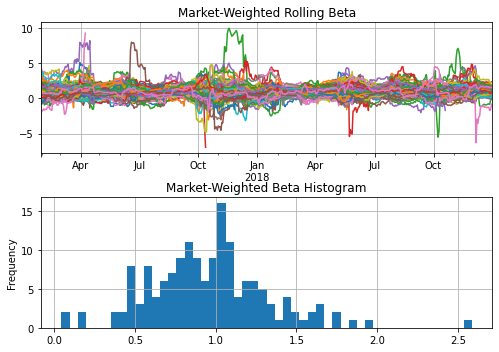

In [22]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_title("Market-Weighted Rolling Beta")
ax2.set_title("Market-Weighted Beta Histogram")
fig.set_size_inches(7,5)
fig.tight_layout()

for col in cap_weighted_beta_df.columns : 
    tmp = cap_weighted_beta_df[col][cap_weighted_beta_df[col].between(-10,10)] #filter values with betas that are too high
    tmp.plot(ax=ax1,grid=True)


cap_weighted_beta_df.mean().plot.hist(ax=ax2,bins=50,grid=True)

In [23]:
cap_weighted_beta_df.mean().plot.hist(ax=ax2,bins=50,grid=True)
print(f"Mean of equally weighted Beta : {equal_weighted_beta.mean().mean()}")
print(f"STD of equally weighted Beta :{equal_weighted_beta.mean().std()}")
print(f"Mean of market-cap weighted Beta : {cap_weighted_beta_df.mean().mean()}")
print(f"STD of market-cap weighted Beta :{cap_weighted_beta_df.mean().std()}")

Mean of equally weighted Beta : 0.995968552503012
STD of equally weighted Beta :0.406846371024396
Mean of market-cap weighted Beta : 0.9560386870080259
STD of market-cap weighted Beta :0.3725543707901908


The equally weighted method of calculating  $\beta$ has a larger mean value and a larger standard deviation compared to the market-cap weighted $\beta$. Individual companies stock returns are more volatile for the equally-weighted portfolio than the market-cap weighted portfolio. An explanation for this observation is that small-caps, which are known to be more risky and volatile are given a small weight, while large-caps that have relatively lower volatility are weighed higher as they can weather changes without significant harm during a downturn in the business cycle.

### 2.4.5 Arbitrage pricing theory (APT)

Arbitrage pricing theory (APT) is a multi-factor assset pricing model which states than an asset's returns can be modelled using a linear relationship between the asset's expected return and a number of systematic factors and an asset's idiosyncratic risk.
\begin{equation}
r_{j} = a_{j} + \lambda_{j1}f_{1} + \lambda_{j2}f_{2} + ... + \lambda_{jn}f_{n} + \epsilon_{j} \tag{14}
\end{equation}
where $f_{n}$ is a systematic factor $\lambda_{jn}$ is factor loading and $\epsilon_{j}$ is the asset's idiosyncratic random shock.

In this part we assume a two-factor model, $R_{m}$ and $R_{s}$
\begin{equation}
r_{i} = a + b_{m_{i}}R_{m} + b_{s_{i}}R_{s} + \epsilon_{i} \tag{15}
\end{equation}

and we will solve for the parameters a, $R_{m}$, $R_{s}$ by solving the ordinary least squares problem.

Since we are appying this to all the 157 European companies. We can rewrite the APT expression in matrix form as 

\begin{equation}
\bf{r}= \bf{A}\bf{x} + \bf{\epsilon} \tag{16}
\end{equation}

\begin{equation}
\begin{pmatrix} 
r_{1} \\
r_{2} \\
...   \\
r_{157}
\end{pmatrix} =

\begin{pmatrix}
1 & b_{m_{1}} & b_{s_{1}} \\  
1 & b_{m_{2}} & b_{s_{2}} \\
... & ... & ...\\
1 & b_{m_{157}} & b_{s_{157}} 
\end{pmatrix}
\begin{pmatrix}
a \\
R_{m} \\ 
R_{s} \\
\end{pmatrix} +

\begin{pmatrix}
\epsilon_{1} \\
\epsilon_{2} \\
... \\ 
\epsilon_{157}


\end{pmatrix}
\tag{17}
\end{equation}

The coefficients of $\bf{A}$ include the sensitivity to market returns $b_{m}$ and the sensitivity to size of the company $b_{s}$. We take $b_{m_{i}}$ to be the corresponding stock's 22-day rolling beta and $b_{s_{i}}$ the correspondings stock's log market capitalization $\ln(mcap)$ 

and $\bf{x}$ can be solved by posing it as an optimization problem. 

\begin{equation}
\min_{\bf{x}} ||\bf{r}-\bf{Ax}||^{2}_{2} \tag{18}
\end{equation}

equation (18) can be solved analytically which gives x = $(\bf{A}^{T}\bf{A})^{-1}\bf{A}^{T}r$

In [24]:
# Drop zero entries otherwise log will give infinity
df_nozeros = df.dropna(1)
bm = rolling_beta(22,df_nozeros,weighted=True,market_returns=R_m)
bs = np.log(df_nozeros['mcap'].iloc[21:])


print(np.shape(bm))
print(np.shape(bs))




(500, 141)
(500, 141)


In [25]:
n = len(bm)
r_2d = df_nozeros['ret'].iloc[21:]
a = []
R_m = []
R_s = []
epsilon = []

for i in range(n) : 
    A = np.ones((bm.shape[1],3)) 
    A[:,1] = bm.iloc[i]
    A[:,2] = bs.iloc[i]
    r = r_2d.iloc[i]
    x = np.linalg.inv(A.T@A)@(A.T@r)
    a.append(np.round(x[0],5))
    R_m.append(np.around(x[1],5))
    R_s.append(np.around(x[2],5))
    epsilon.append(np.around(r-A@x,5))



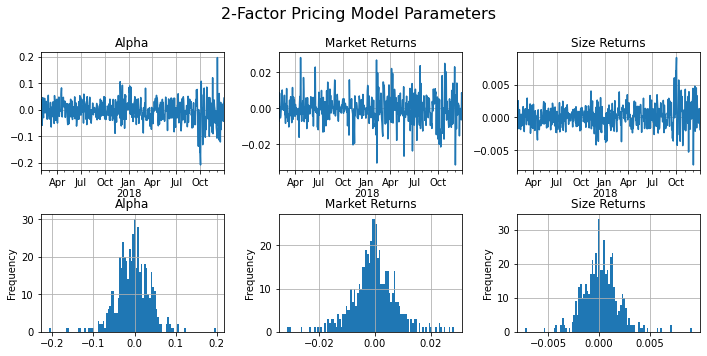

In [26]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(2,3)
fig.suptitle("2-Factor Pricing Model Parameters", fontsize=16)
a = pd.Series(a,index = r_2d.index)
R_M = pd.Series(R_m, index= r_2d.index)
R_S = pd.Series(R_s, index= r_2d.index)
# epsilon = pd.Series(epsilon, index= r_2d.index)
a.plot(legend=False, ax=ax1, title='Alpha', grid=True)
R_M.plot(legend=False, ax=ax2, title='Market Returns', grid=True)
R_S.plot(legend=False, ax=ax3, title='Size Returns', grid=True)

fig.set_size_inches(10,5)
fig.tight_layout()


a.plot.hist(bins= 100, legend=False, ax=ax4, title='Alpha', grid=True)
R_M.plot.hist(bins= 100, legend=False, ax=ax5, title='Market Returns', grid=True)
R_S.plot.hist(bins=100, legend=False, ax=ax6, title='Size Returns', grid=True)

print()

In [27]:
print(f"Mean of a : {np.round(np.mean(a),4)}, SD of a : {np.round(np.std(a),4)}")
print(f"Mean of R_m : {np.round(np.mean(R_m),4)}, SD of R_m : {np.round(np.std(R_m),4)}")
print(f"Mean of R_s : {np.round(np.mean(R_s),4)}, SD of R_s : {np.round(np.std(R_s),4)}")

Mean of a : -0.0042, SD of a : 0.0412
Mean of R_m : -0.0003, SD of R_m : 0.0079
Mean of R_s : 0.0002, SD of R_s : 0.0017


**b) Comment on the magnitude and variance of a, $R_{m}$, and $R_{s}$**

The regressed variables, namely  market return factor $R_{m}$ and the size factor $R_{s}$ are approximately centered at zero. The variance of $R_{m}$ and $R_{s}$ is large compared to the mean value. In conclusion, investing based on these two factors will not give an excess return and it is no better than investing in safe asset's that gives the risk-free-rate.

**c) Correlation of specific return and return through time for every company <$\epsilon_{i}, r_{i}$>** 

We are asked for the correlation through time for every company <$\epsilon_{i}, r_{i}$> where $\epsilon_{i}$ is called the specific return. $\epsilon_{i}$ resembles the excess return not explained by the two-factor model and it should normally be independent or highly uncorrelated with the driving factors of excess return.

Mean of pearson coeff of <r,epsilon> : 0.8114, SD of pearson_coeff : 0.0757


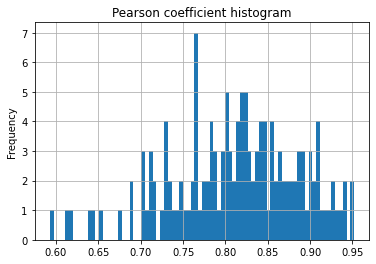

In [28]:
from scipy.stats.stats import pearsonr
companies_pearson = []
epsilon = pd.DataFrame(epsilon, index=r_2d.index, columns = r_2d.columns)
n,m = epsilon.shape
for i in range(m): 
    coeff = pearsonr(epsilon.iloc[:,i],r_2d.iloc[:,i])
    companies_pearson.append(coeff[0])

companies_pearson = pd.Series(companies_pearson, index = r_2d.columns)


fig, ax = plt.subplots(1)
companies_pearson.plot.hist(bins= 80, legend=False, ax=ax, title='Pearson coefficient histogram', grid=True)

print(f"Mean of pearson coeff of <r,epsilon> : {np.round(np.mean(companies_pearson),4)}, SD of pearson_coeff : {np.round(np.std(companies_pearson),4)}")


Based on the figure above, it turns out that the pearson coefficent between the specific return $\epsilon_{i}$ and the return for each company is high, with a mean of 0.81. 

This shouldn't be the case if the factors of multi-factor asset pricing model were true drivers of return. This further reinforces our conclusion in 2.4.5 b) where we have concluded that the size and return factor are not great drivers of returns for the 157 European companies in this time period.


d) 

Number of stable covariances : 0


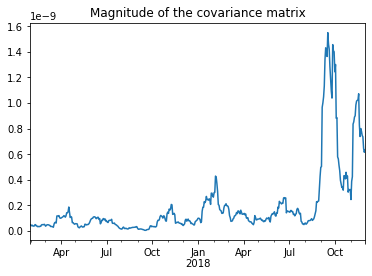

In [29]:

cov_vals = []
mag_vals = [] 
stable_count = 0 
for i, j in zip(range(0,478),range(22,500)) :
    R = np.ones((22,2))
    R[:,0] = R_m[i:j]
    R[:,1] = R_s[i:j]
    cov_vals.append(np.cov(R.T))
    mag_vals.append(np.linalg.det(np.cov(R.T)))
    if np.trace(np.cov(R.T)) <0 and np.linalg.det(np.cov(R.T)) > 0 : 
        stable_count += 1 
cov_vals = pd.Series(cov_vals,index = (r_2d.iloc[:-22]).index)
mag_vals = pd.Series(mag_vals,index = (r_2d.iloc[:-22]).index)

mag_vals.plot(title='Magnitude of the covariance matrix')
print(f"Number of stable covariances : {stable_count}")



$cov(R)$ is small in magnitude for the time period taken into consideration, which means there is very little correlation between the beta factor and the size factor. The covariances also have poor stability. This is because we are estimating the covariances on a daily basis, a monthly or 3-monthly basis would have been a better option.

e) From the previous section b) and c),  we have established that specific returns $\epsilon_{i_{t}}$ is the main explanatory variable behind the excess returns in this two-factor model. Hence it would be interesting to apply Principal Component Analysis on the covariance matrix of the specific returns to further derive insights on it.

Variance explained by the largest 1 eigenvectors 7.35% 
Variance explained by the largest 3 eigenvectors 16.76%
Variance explained by the largest 10 eigenvectors 36.08%
Variance explained by the largest 50 eigenvectors 79.12%
Variance explained by the largest 115 eigenvectors 98.14%


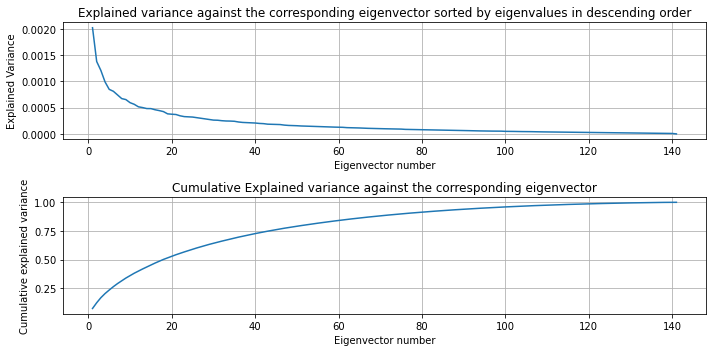

In [30]:
np.shape(np.cov(epsilon.T))
# we will be using np.lingalg.eigh because the covariance matrix is symmetric.
evalues_1, evectors_1 = np.linalg.eigh(np.cov(epsilon.T))

evalues_1 = evalues_1[::-1] #sort in ascending order
evectors_1 = evectors_1[::-1]

fig, (ax1,ax2) = plt.subplots(2,1)

ax1.plot(np.arange(1,len(evectors_1)+1),evalues_1)
ax1.set_ylabel("Explained Variance")
ax1.set_xlabel("Eigenvector number")
ax1.set_title("Explained variance against the corresponding eigenvector sorted by eigenvalues in descending order")
ax1.grid()
ax2.plot(np.arange(1,len(evectors_1)+1),np.cumsum(evalues_1/sum(evalues_1)))
ax2.set_ylabel("Cumulative explained variance")
ax2.set_xlabel("Eigenvector number")
ax2.set_title("Cumulative Explained variance against the corresponding eigenvector")
ax2.grid()

fig.set_size_inches(10,5)
fig.tight_layout()

print(f"Variance explained by the largest 1 eigenvectors {round(sum(evalues_1[:1]) /  sum(evalues_1)*100,2)}% ")
print(f"Variance explained by the largest 3 eigenvectors {round(sum(evalues_1[:3]) /  sum(evalues_1)*100,2)}%")
print(f"Variance explained by the largest 10 eigenvectors {round(sum(evalues_1[:10]) /  sum(evalues_1)*100,2)}%")
print(f"Variance explained by the largest 50 eigenvectors {round(sum(evalues_1[:50]) /  sum(evalues_1)*100,2)}%")
print(f"Variance explained by the largest 115 eigenvectors {round(sum(evalues_1[:115]) /  sum(evalues_1)*100,2)}%")






It takes up to 50 principal components to explain 80% of the variance of the data which indicates that a more sophisticated model is required to better explain the drivers of excess returns of these 157 european companies. However, these 50 principal components might not be intuitive to understand compared to style factors or macroeconomics factors.

## Portfolio Optimization

### 3.1 Adaptive minimum-variance portfolio optimization

### 3.1.1 Derive the optimal weights to construct the minimum variance portfolio

To the derive the optimal weights of a minimum variance portfolio, we minimize the variance measured by $\bf{w}^{T}\bf{C}\bf{w}$ subject to $\bf{w^{T}1} = 1$ as shown in equation (19) . This could be solved analytically by taking the derivative of the lagrangian function. We denote $\bf{w^{*}}$ as the optimal weights.


\begin{equation*}
\min_{\bf{w},\lambda} \bf{J}(\bf{w},\lambda, \bf{C})  = \frac{1}{2}\bf{w}^{T}\bf{C}\bf{w} - \lambda(\bf{w}^{T}1 - 1) \tag{19}
\end{equation*}

\begin{equation*}
\frac{\partial J}{\partial \bf{w}} = \bf{Cw} - \bf{\lambda1} = 0  \Rightarrow \bf{w^{*}} = \bf{C^{-1}}(\lambda1)
\end{equation*}


\begin{equation*}
\frac{\partial J}{\partial \bf{\lambda}} = \bf{w^{T}1-1} = 0 \Rightarrow \bf{(w^{*})^{T}1} = 1
\end{equation*}



\begin{equation*}
{(\bf{C^{-1}}(\lambda1)})^{T}\bf{1} = \bf{1} 
\end{equation*}

\begin{equation*}
\bf{\lambda1^{T}}(C^{-1})^{T}1 = 1 
\end{equation*}

\begin{equation*}
\lambda = \frac{1}{\bf{1}^TC^{-1}\bf{1}}
\end{equation*}

subtituting this back in the optimal weights $\bf{w^{*}}$ gives : 

\begin{equation*}
\bf{w^{*}} = \frac{C^{-1}\bf{1}}{1^{T}C^{-1}1}
\end{equation*}



The theoretical optimal minimum variance of the portfolio is then given by :

\begin{equation*}

\bf{(w^{*})^{T}Cw^{*}} = \frac{1}{1^{T}C^{-1}1} = \lambda 

\end{equation*}

which is the lagrange multiplier $\lambda$

### 3.2 Comparing the min-variance strategy to the equal-weighted strategy


We are told to test the min-variance portfolio strategy on the last 10 stocks of the csv file 'fsp_case_31_BSD.csv'. We split the stock returns of the last 10 stocks into two equally sized sets based on chronological order. We will train on the first-half of the dataset (Jan 2017 - Dec 2017) , and test on the second-half (Jan 2018 - Dec 2018) of the dataset. We will then analyse how our backtest strategy would have done ex-post.

,Cumulative Returns,Variance,Theoretical Variance
Min-Variance Portfolio (train),0.249062,0.000029,0.000029
Min-Variance Portfolio(test),-0.117582,0.000082,0.000029
Equally-Weighted Portfolio(train),0.223484,0.000037,0.000000
Equally-Weighted Portfolio(test),-0.123503,0.000079,0.000000


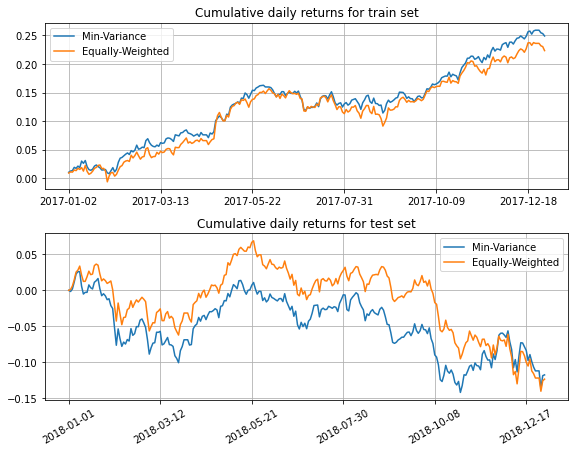

In [31]:
from IPython.display import display,HTML 

data = pd.read_csv('data/fsp_case_31_BSD.csv', index_col =0, header=[0,1])
ten_comps = data['ret'].iloc[:, -10:]
n = int(len(ten_comps)/2)
train_data, test_data = ten_comps[:n], ten_comps[n:] 

def get_weights_lamb(train_data):
    C = train_data.cov()
    ones = np.ones(10)
    w_opt = (np.linalg.inv(C)@ones)/(ones.T@np.linalg.inv(C)@ones)
    lamb = 1 /(ones.T@np.linalg.inv(C)@ones)
    return w_opt, lamb


w_opt,lamb = get_weights_lamb(train_data)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_title("Cumulative daily returns for training data")
ax2.set_title("Cumulative daily returns for test data")
fig.set_size_inches(8,6)
fig.tight_layout()

########## Min-Variance PORTFOLIO#########
# Calculate the cum_return of the test_data

cum_return = pd.DataFrame.cumsum(train_data)

cum_return_min_var_train = cum_return.mul(w_opt)
portfolio_cum_return_min_var_train = cum_return_min_var_train.sum(axis=1)
portfolio_cum_return_min_var_train.plot(label = "Min-Variance",legend=True, ax=ax1)



cum_return = pd.DataFrame.cumsum(test_data)
cum_return_min_var_test = cum_return.mul(w_opt)
portfolio_cum_return_min_var_test = cum_return_min_var_test.sum(axis=1)
portfolio_cum_return_min_var_test.plot(label = "Min-Variance",legend=True, ax=ax2)



portfolio_var_min_var_train = (train_data.mul(w_opt).sum(axis=1)).var()
portfolio_var_min_var_test = (test_data.mul(w_opt).sum(axis=1)).var()






##########Equally-Weighted Portfolio#############
# Calculate the cum_return of equally-weighted


cum_return = pd.DataFrame.cumsum(train_data)
cum_return_eq_weight_train = cum_return.mul(np.full(10,1/10))
portfolio_cum_return_eq_weight_train = cum_return_eq_weight_train.sum(axis=1)
portfolio_cum_return_eq_weight_train.plot(grid=True, ax=ax1, title="Cumulative daily returns for train set",label = "Equally-Weighted", legend=True)

cum_return = pd.DataFrame.cumsum(test_data)
cum_return_eq_weight_test = cum_return.mul(np.full(10,1/10))
portfolio_cum_return_eq_weight_test = cum_return_eq_weight_test.sum(axis=1)
portfolio_cum_return_eq_weight_test.plot(grid=True, ax=ax2, title="Cumulative daily returns for test set",label = "Equally-Weighted", legend=True)

plt.xticks(rotation = 30)

portfolio_var_eq_weight_train = (train_data.mul(np.full(10,1/10)).sum(axis=1)).var()
portfolio_var_eq_weight_test = (test_data.mul(np.full(10,1/10)).sum(axis=1)).var()



emp_results = {'Cumulative Returns': [portfolio_cum_return_min_var_train[-1], portfolio_cum_return_min_var_test[-1], portfolio_cum_return_eq_weight_train[-1],portfolio_cum_return_eq_weight_test[-1]  ],
               'Variance' : [portfolio_var_min_var_train, portfolio_var_min_var_test, portfolio_var_eq_weight_train, portfolio_var_eq_weight_test],
               'Theoretical Variance' : [lamb, lamb, 0 ,0]
}

emp_results_df = pd.DataFrame(emp_results, index=['Min-Variance Portfolio (train)','Min-Variance Portfolio(test)', 'Equally-Weighted Portfolio(train)', 'Equally-Weighted Portfolio(test)'])
display(emp_results_df)






The variance obtained from the test-set of the min-variance portfolio exceeds the theoretical minimum variance by a factor of approximately 3. The variance is much higher even compared to an equally-weighted portfolio. This can be explained by the fact that the minimum variance portfolio would only minimize the variance provided the covariance matrix $\bf{C}$ is accurate. We made the assumption that the covariance matrix of 2017-2018 was the same and static throughout 2018-2019 where in fact it is dynamic which changes with time. The covariance between certain asset returns could have changed dramatically throughout 2017-2019 and our static Covariance matrix would not have captured that variation. We ended up having a variance that is 3 times the theoretical variance and low cumulative returns.

### 3.2.3 Adaptive time-varying minimum variance portfolio

In this section we attempt to find the optimal weights with an adaptive covariance matrix that changes with time. We calculate new weights daily based on a rolling window of length M = 22 days. Again, we split the into 50% training and 50% test data exactly like part 3.2.2.


,Cumulative Returns,Variance,Theoretical Variance
Min-Variance Portfolio (train),0.249062,0.000029,0.000029
Min-Variance Portfolio(test),-0.117582,0.000082,0.000029
Equally-Weighted Portfolio(train),0.223484,0.000037,0.000000
Equally-Weighted Portfolio(test),-0.123503,0.000079,0.000000
Adaptive-Weighted Portfolio,0.093267,0.000099,0.000000


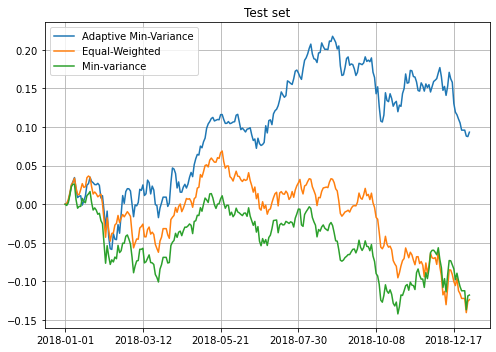

In [32]:
window = 22

new_data = train_data.iloc[-window:].append(test_data)
mean_t = new_data.rolling(window,axis=0).mean()
cov_matrix = []


sliding_t = 0 
for i in np.arange(window-1,len(mean_t)) : 
    current_mean = mean_t.iloc[i]
    C_t = np.zeros((10,10))
    for j in np.arange(sliding_t,sliding_t+window-1) :
        A = (np.array(new_data.iloc[j]) - np.array(current_mean))
        A = A.reshape(10,1)
        C_t += A@(A.T)
    sliding_t = sliding_t+1
    cov_matrix.append(C_t/window)


# cov_matrix = pd.DataFrame(cov_matrix)
w_opt_vals = [] 
lamb_vals = [] 
for i in np.arange(0,len(mean_t)-window+1) :
    C = cov_matrix[i]
    ones = np.ones(10)
    w_opt_vals.append((np.linalg.inv(C)@ones)/(ones.T@np.linalg.inv(C)@ones))
    lamb_vals.append(1 /(ones.T@np.linalg.inv(C)@ones))



fig, ax1 = plt.subplots(1,1)

w_opt_pd = pd.DataFrame(w_opt_vals, index = new_data[window-1:].index, columns = new_data.columns)
return_adaptive_test = new_data.mul(w_opt_pd, fill_value = 0)[window:]
cum_return_adaptive_test = pd.DataFrame.cumsum(return_adaptive_test)


portfolio_cum_return_adaptive_test = cum_return_adaptive_test.sum(axis=1)
portfolio_var_adaptive_weight_test = (return_adaptive_test.sum(axis=1)).var()
portfolio_cum_return_adaptive_test.plot(label = "Adaptive Min-Variance",legend=True, ax=ax1, title= "Test set",grid = 'on')
portfolio_cum_return_eq_weight_test.plot(label = "Equal-Weighted",legend=True, ax=ax1)
portfolio_cum_return_min_var_test.plot(label = 'Min-variance', legend=True, ax=ax1, grid = 'on')


emp_results = {'Cumulative Returns': [portfolio_cum_return_min_var_train[-1], portfolio_cum_return_min_var_test[-1], portfolio_cum_return_eq_weight_train[-1],portfolio_cum_return_eq_weight_test[-1], portfolio_cum_return_adaptive_test[-1]],
               'Variance' : [portfolio_var_min_var_train, portfolio_var_min_var_test, portfolio_var_eq_weight_train, portfolio_var_eq_weight_test, portfolio_var_adaptive_weight_test ],
               'Theoretical Variance' : [lamb, lamb, 0 ,0,0]
}

emp_results_df = pd.DataFrame(emp_results, index=['Min-Variance Portfolio (train)','Min-Variance Portfolio(test)', 'Equally-Weighted Portfolio(train)', 'Equally-Weighted Portfolio(test)', 'Adaptive-Weighted Portfolio'])
display(emp_results_df)


fig.set_size_inches(7,5)
fig.tight_layout()





The adaptive-weighted method is able to capture the time-varying nature of market dynamics evident in the comparably large cumulative returns of 10% compared to the min-variance and equally-weighted portfolios. A caveat of this method is that the portfolio weight updates are done every day, and assuming a transaction fee of 0.5% being charged for every trade you make, your cumulative returns of 10% could easily be negated by the transactions fees. To reduce transaction fees, we can restrain the number of weight changes made by including it into our constrained optimisation problem or simply recompute the min-variance portfolio 3-6 months.


**Elaborate on whether there exist a different method to compute the sample
covariance matrix?**

Intuitively, recent events should be more relevant than events that have happened longer in the past. Hence, a more accurate method of computing the covariance matrix is by applying an exponential weight decay to older events.

## 4.1 Robust Statistics and Non Linear Methods

### 4.1 Data Import and Exploratory Data Analysis 

In [232]:
df_aapl = pd.read_csv('data\AAPL.csv')
df_ibm = pd.read_csv('data\IBM.csv')
df_jpm = pd.read_csv('data\JPM.csv')
df_dji = pd.read_csv('data\DJI.csv')

title_list = ['AAPL', 'IBM', 'JPM', 'DJI']
df_list = [df_aapl, df_ibm, df_jpm,df_dji]

for df in df_list : 
    df.set_index('Date',inplace=True)
    df['Daily Returns'] = (df['Adj Close'] - df['Open']) / df['Open']

In [178]:
from scipy.stats import describe 
# key_stats = ['Mean', 'Metdian','Std Dev', '']
from IPython.display import display



dict = {}
row_index = ['Mean','Variance','Skewness','Kurtosis']

for title,df in zip(title_list,df_list) : 
    print(title)
    tmp_dict = {}
    tmp_dict[title] = describe(df)
    df_stats = pd.DataFrame(columns = df.columns, index = [row_index])
    df_stats.loc['Mean'] = tmp_dict[title].mean
    df_stats.loc['Variance'] = tmp_dict[title].variance
    df_stats.loc['Skewness'] = tmp_dict[title].skewness
    df_stats.loc['Kurtosis'] = tmp_dict[title].kurtosis
    dict[title] = df_stats
    display(dict[title])





AAPL


,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Mean,187.686694,189.561753,185.823705,187.711953,186.174273,32704750.199203,-0.007905
Variance,490.428517,496.468653,484.387139,491.097551,479.814326,201064504454829.9375,0.000193
Skewness,0.258361,0.298587,0.219169,0.262269,0.28903,1.732882,0.186957
Kurtosis,-0.918326,-0.930095,-0.923264,-0.937763,-0.933443,4.243138,1.616607


IBM


,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Mean,138.454382,139.492072,137.329243,138.363108,134.902751,5198937.450199,-0.024774
Variance,146.756461,141.921459,148.953056,144.675747,113.88408,11081944923551.871094,0.000337
Skewness,-0.671977,-0.618979,-0.709175,-0.678162,-0.806366,3.173783,0.126283
Kurtosis,-0.597488,-0.635063,-0.574652,-0.596277,-0.436325,11.539397,-0.348875


JPM


,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Mean,108.707689,109.652072,107.682988,108.606574,107.26259,14700689.243028,-0.012979
Variance,28.719748,27.069858,29.512463,28.095087,23.360944,28620045092323.828125,0.000219
Skewness,-0.418292,-0.373969,-0.375257,-0.372609,-0.342429,1.68332,-0.120212
Kurtosis,-0.339957,-0.557193,-0.284246,-0.412533,-0.127158,4.318628,0.383772


DJI


,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Mean,25001.257268,25142.041965,24846.002226,24999.153581,24999.153581,332889442.231076,-0.000043
Variance,737597.055479,664557.495535,815954.839954,738107.974296,738107.974296,8850677260487649.0,0.000083
Skewness,-0.3699,-0.237934,-0.453715,-0.377872,-0.377872,1.729147,0.006904
Kurtosis,0.452304,0.092003,0.522736,0.368922,0.368922,5.717736,3.542433


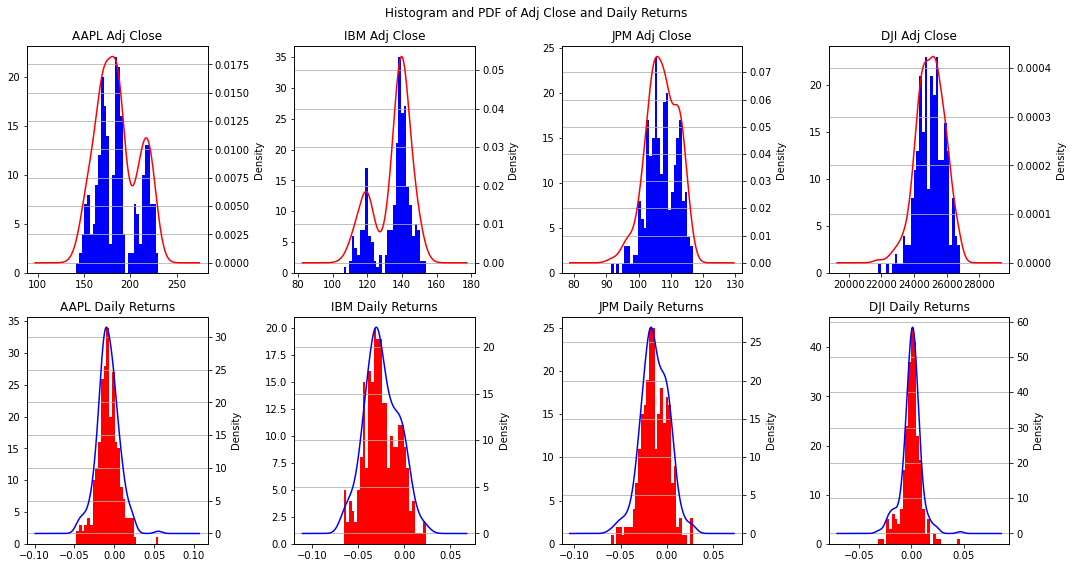

In [179]:
fig, axes = plt.subplots(2,4)
fig.suptitle('Histogram and PDF of Adj Close and Daily Returns')
fig.set_size_inches(15,8)

for i, (title,df) in enumerate(zip(title_list,df_list)) : 

    axes[0][i].set_title(f'{title} Adj Close')
    axes[1][i].set_title(f'{title} Daily Returns')

    axes[0][i].hist(df['Adj Close'], bins = 30, color = 'b')
    df['Adj Close'].plot.kde(ax = axes[0][i].twinx(), color='r', grid=True)
    axes[1][i].hist(df["Daily Returns"], bins=30, color='r')
    df['Daily Returns'].plot.kde(ax = axes[1][i].twinx(), color='b', grid=True)

fig.tight_layout()

With regards to the Adjusted Close price, only DJI's histogram plot appears to be normally distributed at a mean of 250000 while for others, the histogram plot is not symmetric. DJI is a price-weighted measurement stock market index of 30 prominent companies. We have shown in Part 1 that daily closing prices can be modelled as a random walk, and since DJI is simply an aggregation of random walks, we will eventually achieve a normal distribution symmetrical about the mean of the closing prices of the 30 companies.

With regards to the Daily Returns, they are normally distributed while being centered at zero. This aligns with the insigts derived from Part 1. 



**4.1.3 For each stock, plot the adj. close, the associated rolling mean (using a 5-day window), and the ±1.5× standard deviations relative to the rolling mean. In a separate figure, repeat the steps above using the
rolling median (using a 5-day window) and ±1.5× median absolute deviation relative to the rolling
median. Comment on the difference, if any, between the two figures.**


,Mean - STD Without Outlier,Median-MAD Without Outlier
AAPL,30,66
IBM,31,67
JPM,33,65
DJI,30,62


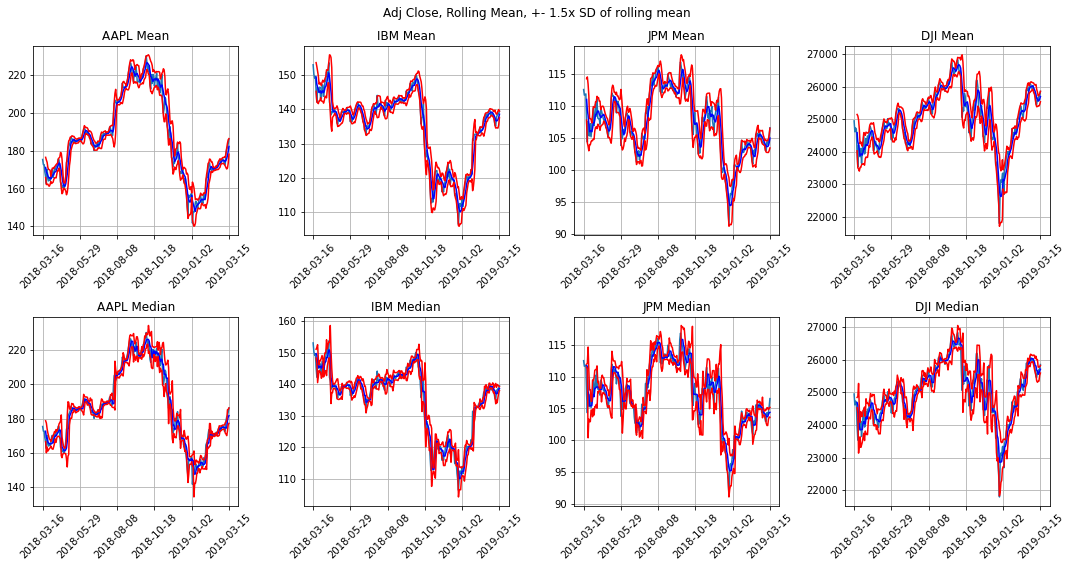

In [192]:
from statsmodels.robust.scale import mad
fig, axes = plt.subplots(2,4)
fig.suptitle('Adj Close, Rolling Mean, +- 1.5x SD of rolling mean')
fig.set_size_inches(15,8)

for i, (title,df) in enumerate(zip(title_list,df_list)) :
    axes[0][i].set_title(f'{title_list[i]} Mean')
    

    axes[0][i].plot(df['Adj Close'])
    

    axes[0][i].plot(df['Adj Close'].rolling(window=5).mean(), color = 'b', label = '5 day Rolling Mean ')
    

    std = df['Adj Close'].rolling(window=5).std()
    axes[0][i].plot(df['Adj Close'].rolling(window=5).mean() + 1.5*std, color = 'r')
    axes[0][i].plot(df['Adj Close'].rolling(window=5).mean() - 1.5*std, color = 'r')
    axes[0][i].grid()
    axes[1][i].grid()



    axes[1][i].set_title(f'{title_list[i]} Median')
    axes[1][i].plot(df['Adj Close'])
    axes[1][i].plot(df['Adj Close'].rolling(window=5).median(), color = 'b', label = '5 day Rolling Median ')
    made = (df['Adj Close'].rolling(window=5)).apply(mad)
    axes[1][i].plot(df['Adj Close'].rolling(window=5).median() + 1.5*made, color = 'r')
    axes[1][i].plot(df['Adj Close'].rolling(window=5).median() - 1.5*made, color = 'r')

    # x tick parameters
    axes[0][i].set_xticks(axes[0][i].get_xticks()[::50])
    axes[1][i].set_xticks(axes[1][i].get_xticks()[::50])
    
    axes[0][i].xaxis.set_tick_params(rotation=45)
    axes[1][i].xaxis.set_tick_params(rotation=45)

fig.tight_layout()



def find_outliers(stock, name, mean = True) :
    close_price = stock['Adj Close']

    rolling_price = close_price.rolling(window=5)
    dev = rolling_price.std() if mean == True else rolling_price.apply(mad)
    upper_std = rolling_price.mean() + 1.5*dev if mean == True else rolling_price.median() + 1.5*dev
    lower_std = rolling_price.mean() - 1.5*dev if mean == True else rolling_price.median() - 1.5*dev

    
    return len(close_price[close_price > upper_std]) + len(close_price[close_price < lower_std])

outlier_mean_vals = []
outlier_median_vals = []
for title, df in zip(title_list, df_list) : 
    
    outlier_mean_vals.append(find_outliers(df,title, mean=True))
    outlier_median_vals.append(find_outliers(df,title, mean=False))


df_outliers = pd.DataFrame(columns = ['Mean - STD Without Outlier', 'Median-MAD Without Outlier'], index = title_list)


for i in range(len(title_list)) :
    df_outliers.loc[title_list[i]] = [outlier_mean_vals[i], outlier_median_vals[i]]

display(df_outliers)








By inspection, there isn't a clear difference between the 'mean' method of calculating outliers compared to the 'median' method of calculating outliers. But based on the data I have collected, the number of outliers using the 'mean' method is much more than the number of outliers achieved from the 'median' outlier.


**4.1.4 Introduce outlier points for the adj. close in the four dates {2018-05-14, 2018-09-14, 2018-12-14, 2019-01-14} with a value equal to 1.2 × the maximum value of the column. Comment on the impact of the outlier
points in Part 3.**


In [199]:
outlier_dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
extreme_copies = [df_list[0].copy(deep=True), df_list[1].copy(deep=True), df_list[2].copy(deep=True), df_list[3].copy(deep=True)]
for cop in extreme_copies : 
    max_val = cop['Adj Close'].max()
    for date in outlier_dates : 
        cop['Adj Close'][date] = 1.2 * max_val

num_outlier_mean_vals = []
num_outlier_median_vals = []
for i in range(len(extreme_copies)) : 
    num_outlier_mean_vals.append(find_outliers(extreme_copies[i],title_list[i], mean=True))
    num_outlier_median_vals.append(find_outliers(extreme_copies[i],title_list[i], mean=False))


df_outliers['Mean - STD with Outliers'] = num_outlier_mean_vals
df_outliers['Mean - MAD with Outliers'] =  num_outlier_median_vals

display(df_outliers)


,Mean - STD Without Outlier,Median-MAD Without Outlier,Mean - STD with Outliers,Mean - MAD with Outliers
AAPL,30,66,32,66
IBM,31,67,31,65
JPM,33,65,33,66
DJI,30,62,29,61


The 5-day window which includes the outlier significantly affects the mean value's Z-score range while the median is largely unchanged.

 The acceptable Z-score range for the median method is largely unchanged in the regions with outliers. The median method is comparably more robust than the mean estimate in presence of outliers.



**5. Generate a box plot for the adj. close for each stock, describe the information the box plot conveys and elaborate on any other observations you may have.**


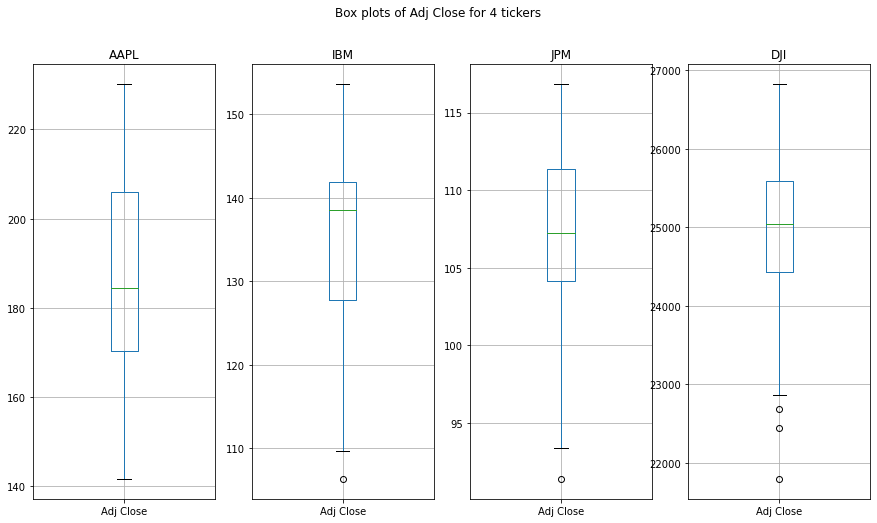

In [206]:
fig, axes = plt.subplots(1,4)
fig.suptitle('Box plots of Adj Close for 4 tickers')
fig.set_size_inches(15,8)
for i,(title,df) in enumerate(zip(title_list,df_list)) : 
    df.boxplot(column=['Adj Close'], grid=True, ax=axes[i])
    axes[i].set_title(title)




Box plots provide an illustrative example of the minimum value, first quartile, median, third quartile and the maximum value.


The inter-quartile range of AAPL is much larger than the 3 other stocks, this is an indication that it's price movement was volatile but mostly within the bounds of the interquartile range. While for the other 3 tickers, they experienced a significant move up from the lows and fluctuated in smaller proportions compared to AAPL, near the median value, throughout the year.

## 4.2 Robust Estimators
### 4.2.1 Custom Robust Estimators
In this section, we will explore the use of robust estimators in the presence of outliers. We will create robust estimations of the median, interquartile range (IQR) and median absolute deviation (MAD).

In [208]:
def robust_median(data) : 
    sorted_vals = data.sort_values()
    n = len(sorted_vals)
    index = (n - 1) // 2 
    if (n % 2) : 
        return sorted_vals[index]
    else : 
        return (sorted_vals[index] + sorted_vals[index+1]) / 2.0

def robust_IQR(data) :
    sorted_vals = data.sort_values()
    n = len(sorted_vals)
    p_25 = sorted_vals[n*1/4]
    p_75 = sorted_vals[n*3/4]
    return p_75-p_25

# Median of Deviations 
def robust_MAD(data) :
    median = robust_median(data)
    return robust_median(abs(data-median)) 

### 4.2.2 Complexity Analysis 

The `.sort_values()` pandas method applies quicksort under the hood, hence we have a best-case sorting time of $O(log(n))$, worst-case of $O(n^{2})$ and average sorting time of $O(nlog(n))$ . Index look-ups have a constant complexity, $O(1)$.

The operations of finding the median in `robust_median()` is hence $O(nlog(n))$ on average.

The `robust_IQR()` applies the sorting method `.sort_values()` twice. It's complexity is more expensive by a constant factor which is ignored in big O notation hence it's complexity is also $O(nlog(n))$ on average.

Finallyt the `robust_MAD()` function calls the `robust_median()` function twice. It's complexity is more expensive by the `robust_median()` by a factor of two and hence is also $O(nlog(n))$ on average.

### 4.2.3 Break down points of different estimators

The finite sample breakdown point of an estimator is defined as the fraction of the sample size which can be arbitrarily changed without affecting the estimator's quality significantly. It is a measure of the data's robustness. 

In the case of the median estimator, it's computation is bASed on the middle value of the sorted values, hence half of the sequences' length minus one can be contaminated. The number up to $\frac{1}{2} - \frac{1}{2n}$ can be contaminated and the median would still remain unchanged. The asymptotic breakdown point as n tends to infinity is $\frac{1}{2}$.


Similarly, the IQR estimator has a breakdown point of $\frac{1}{4}$ since it can be seen as applying the median operation on half the sequence length. The MAD has the same breakdown point as the median of $\frac{1}{2}$, since it computes the median and then finds the median of absolute deviation from the median.

## 4.3 Robust and Ordinary Least Squares Regression 

The regression problem solved by the OLS method is defined mathematically as : 

\begin{equation}

\bf{r = Ax + e } \tag{20}
\end{equation}

where $\bf{r}$ is the returns for the equity we are comparing to DJI. $A$ has first column of 1's and second column of DJI returns.

We pose this as an optimization problem where we find 

\begin{equation}
\min_{\bf{x}} ||\bf{r - Ax}||^{2} \tag{21}
\end{equation}

where eq(21) can be solved analytically to give 

\begin{equation*}
\bf{x^{*} = (A^{T}A)^{-1}A^{T}r}
\end{equation*}



,AAPL,IBM,JPM
Alpha,-0.007861,-0.024734,-0.012938
Beta,1.022438,0.940002,0.942913
MSE,0.000105,0.000262,0.000144
MSE of interquartile points,0.000006,0.000028,0.000014


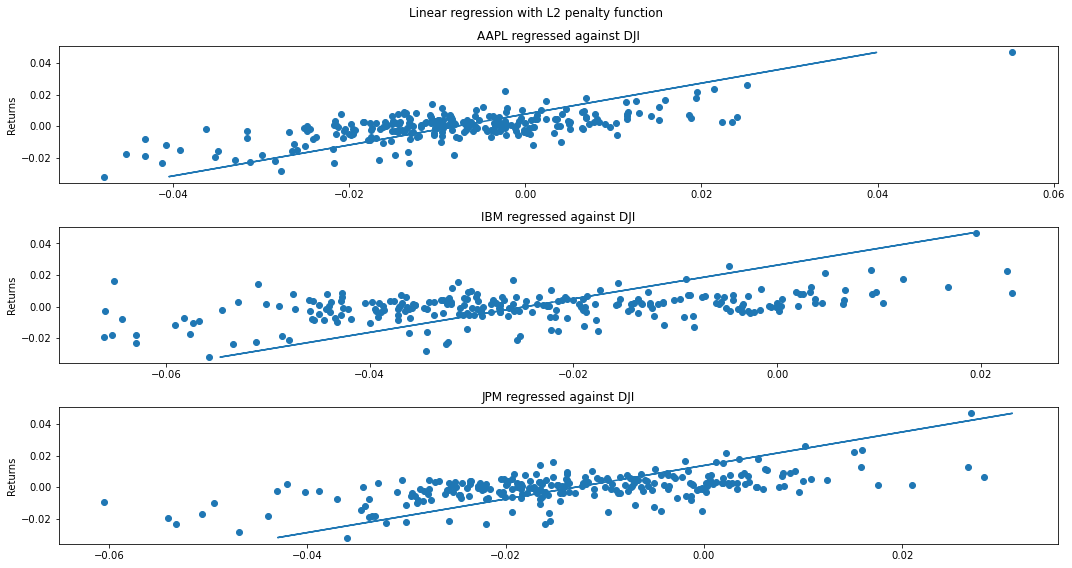

In [325]:
from sklearn.metrics import mean_squared_error
dji_ret = df_dji['Daily Returns']
n = len(dji_ret)
A = np.vstack((np.ones(n), dji_ret)).T
no_dji_list = df_list[:-1]
no_dji_title_list = title_list[:-1]


fig, axs = plt.subplots(3,1)
fig.set_size_inches(15,8)
fig.suptitle('Linear regression with L2 penalty function')

results = pd.DataFrame(columns = no_dji_title_list, index = ['Alpha','Beta','MSE', 'MSE of interquartile points'])
for i,(df,title) in enumerate(zip(no_dji_list, no_dji_title_list)) : 
    r = df['Daily Returns']
    regressed_var = np.linalg.inv(A.T@A)@A.T@r
    A_2_IQR = np.sort(dji_ret)[int(len(dji_ret)/4) : int(len(dji_ret)*3/4)]
    A_IQR = np.vstack((np.ones(len(A_2_IQR)), A_2_IQR)).T
    r_IQR = np.sort(r)[int(len(r)/4) : int(len(r)*3/4)]

    results[title]['Alpha'] = regressed_var[0]
    results[title]['Beta'] = (regressed_var[1])
    results[title]['MSE'] = mean_squared_error(r,A@regressed_var)
    results[title]['MSE of interquartile points'] = mean_squared_error(r_IQR,A_IQR@regressed_var)


    axs[i].plot(A@regressed_var, dji_ret)
    axs[i].set_title(f'{title} regressed against DJI')
    axs[i].scatter(r,dji_ret)
    axs[i].set_ylabel('Returns')
fig.tight_layout()
results


This regression method has an $L_{2}$ penalty function and hence is sensitive to outliers. 

IBM has the largest Mean-Squared Error, as we can see some points on the far left of the diagram 'IBM regressed against DJI' clearly do not fit on the line. The question we will explore next is if there is a method to replace Ordinary Least Squares with a more robust linear regression model.


A method to counter this problem is to run a simple exploratory data analysis and discard the outliers. The problem is that this method is hard to scale when the number of dimensions and datapoints increase exponentially. A scalable solution to this problem is the Huber regressor with objective function defined as : 
\begin{equation}
  L =
    \begin{cases}
      || r- Ax ||^{2} \text{for} \frac{||r-Ax||}{\sigma} < \epsilon  \\  \tag{22}
      || r -Ax ||  \text{for} \frac{||r-Ax||}{\sigma} \geq \epsilon  \\ 
    \end{cases} 

\end{equation}


The Huber regressor penalizes points with an $L_{2} $ norm within a certain range away from the mean and penalizes points with a $L_{1}$ norm outside of the range, which are points classified as outliers.



,AAPL,IBM,JPM
Alpha,-0.008641,-0.025895,-0.014121
Beta,1.066043,0.97231,0.957513
MSE,0.000106,0.000264,0.000146
MSE of interquartile points,0.000005,0.000025,0.000013


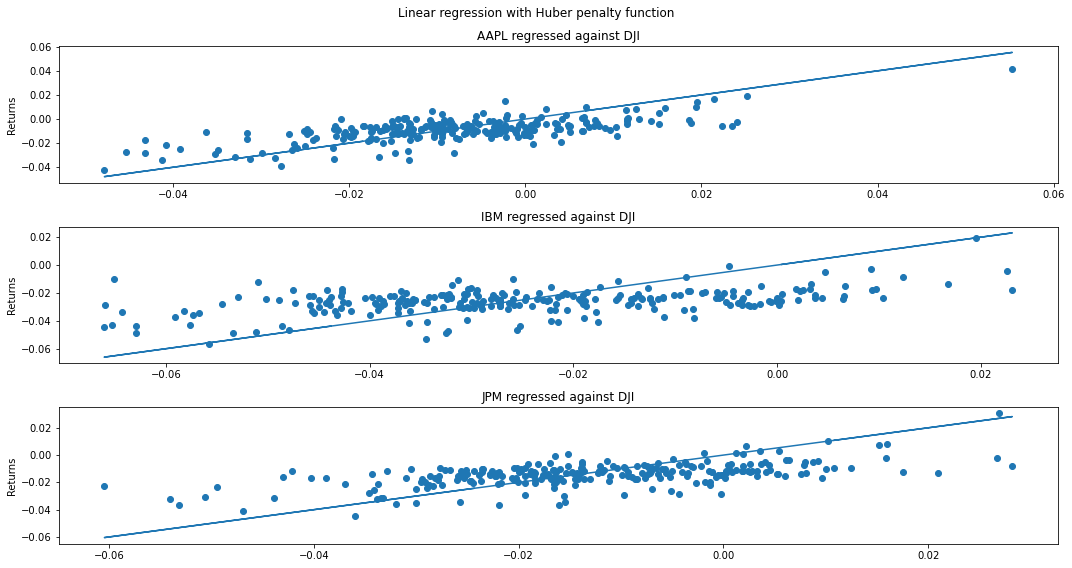

In [322]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
huber_regressor = linear_model.HuberRegressor(epsilon=1.0)

fig, axs = plt.subplots(3,1)
fig.set_size_inches(15,8)
fig.suptitle('Linear regression with Huber penalty function')
results = pd.DataFrame(columns = no_dji_title_list, index = ['Alpha','Beta','MSE', 'MSE of interquartile points'])
for i,(df,title) in enumerate(zip(no_dji_list, no_dji_title_list)) : 
    r = df['Daily Returns']
    A = dji_ret.copy().values.reshape(-1,1)
    r = r.copy().values.reshape(-1,1)
    huber_regressor.fit(A,r)
    pred = huber_regressor.predict(A)
    A = A.flatten() ; r = r.flatten()
    A_IQR = np.sort(A)[int(len(A)/4) : int(len(A)*3/4)]; 
    r_IQR = np.sort(r)[int(len(r)/4) : int(len(r)*3/4)]
    pred_inter = huber_regressor.predict(A_IQR.reshape(-1,1))
    results[title]['Alpha'] = float(huber_regressor.intercept_)
    results[title]['Beta'] = float(huber_regressor.coef_)
    results[title]['MSE'] = mean_squared_error(r,pred)
    results[title]['MSE of interquartile points'] = mean_squared_error(r_IQR, pred_inter)
    axs[i].plot(r, r)
    axs[i].set_title(f'{title} regressed against DJI')
    axs[i].scatter(r,pred)
    axs[i].set_ylabel('Returns')
fig.tight_layout()
results



We can see that the 'MSE of interquartile points' of the Huber Regressor is much lower than the 'MSE of interquartile points' for the OLS regressor.This is because the Huber regressor penalizes the 'outliers' much less by using a $L_{1}$ norm. This effectively puts less weight on the outliers and fits a linear function which is more robust.

### 4.4 Robust Trading Strategies

In this section I will be implementing a simple trading strategy called the *Moving Average Crossover* which is based on the following rules 

a. Buy X shares of a stock when its 20-day MA > 50-day MA

b. Sell X shares of the stock when its 20-day MA < 50-day MA



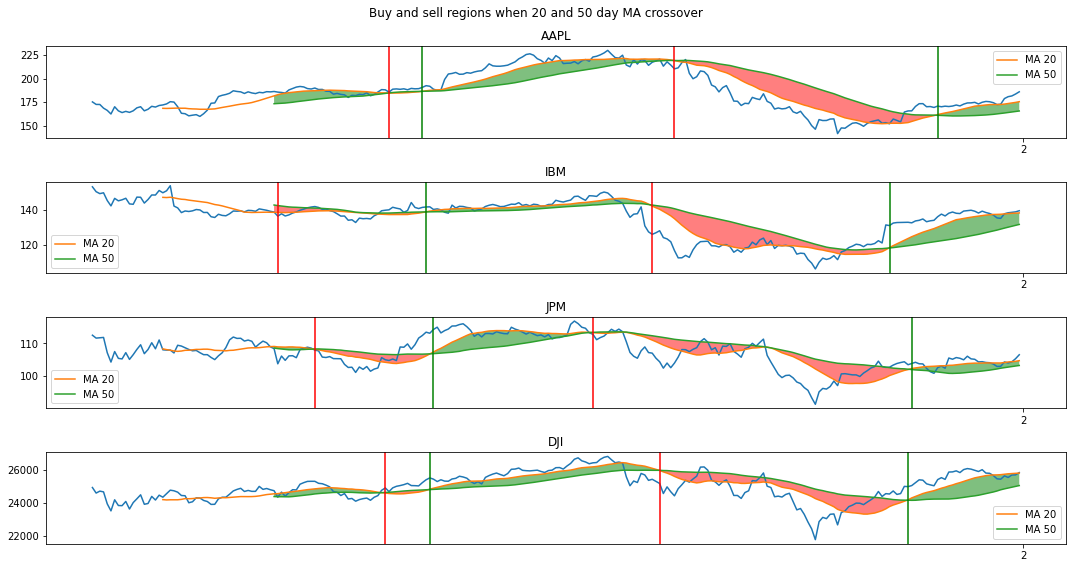

In [389]:
def MA_20(price_series):
    return price_series.rolling(20).mean()

def MA_50(price_series) : 
    return price_series.rolling(50).mean()

fig,axs = plt.subplots(4,1)
fig.set_size_inches(15,8)
fig.suptitle('Buy and sell regions when 20 and 50 day MA crossover')
for i in range(len(df_list)) : 
    df = df_list[i]
    ma_20 = MA_20(df['Adj Close'])
    ma_50 = MA_50(df['Adj Close'])
    sell = False 
    dates_to_buy = [] 
    dates_to_sell=[]
    for j in range(len(ma_50)-50) :
        if not np.isnan(ma_20[j+50]) and  not np.isnan(ma_50[j+50]) :
            if (ma_20[j+50] > ma_50[j+50]) :
                if sell : 
                    dates_to_buy.append(ma_20.index[j+50])
                    sell = False
            if (ma_20[j+50] < ma_50[j+50]) :
                if not sell : 
                    dates_to_sell.append(ma_20.index[j+50])
                    sell = True


                          
    axs[i].fill_between(ma_20.index, ma_50, ma_20, where=(ma_20 > ma_50), facecolor = 'g', alpha=0.5) 
    axs[i].fill_between(ma_20.index, ma_50, ma_20, where=(ma_50 > ma_20), facecolor = 'r', alpha=0.5) 
    axs[i].plot(df['Adj Close'])
    axs[i].plot(ma_20, label = 'MA 20')
    axs[i].plot(ma_50, label = 'MA 50')

    axs[i].set_xticks(date[::30])
    axs[i].set_xticklabels(date[::30])
    axs[i].set_title(title_list[i])
    for date in dates_to_buy : 
        axs[i].axvline(date, color='g')
    for date in dates_to_sell : 
        axs[i].axvline(date, color = 'r')
    axs[i].legend()

fig.tight_layout()
    




